(perm_income_cons)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# {index}`Permanent Income II: LQ Techniques <single: Permanent Income II: LQ Techniques>`

```{index} single: Models; Permanent Income
```

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

## Overview

This lecture continues our analysis of the linear-quadratic (LQ) permanent income model of savings and consumption.

As we saw in our {doc}`previous lecture <perm_income>` on this topic, Robert Hall {cite}`Hall1978` used the LQ permanent income model to restrict and interpret intertemporal comovements of nondurable consumption, nonfinancial income, and financial wealth.

For example, we saw how the model asserts that for any covariance stationary process for nonfinancial income

- consumption is a random walk
- financial wealth has a unit root and is cointegrated with consumption

Other applications use the same LQ framework.

For example, a model isomorphic to the LQ permanent income model has been used by Robert Barro {cite}`Barro1979` to interpret intertemporal comovements of a government's tax collections, its  expenditures net of debt service, and its public debt.

This isomorphism means that in analyzing the LQ permanent income model, we are in effect also analyzing  the Barro tax smoothing model.

It is just a matter of appropriately relabeling the variables in Hall's model.

In this lecture, we'll

* show how the solution to the LQ permanent income model can be obtained using LQ control methods.
* represent the model as a linear state space system as in {doc}`this lecture <linear_models>`.
* apply [QuantEcon](http://quantecon.org/quantecon-py)'s [LinearStateSpace](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lss.py) class to characterize statistical features of the consumer's optimal consumption and borrowing plans.

We'll then use these characterizations to construct a simple model of cross-section wealth and
consumption dynamics in the spirit of Truman Bewley {cite}`Bewley86`.

(Later we'll study other Bewley models---see {doc}`this lecture <aiyagari>`.)

The model will prove useful for illustrating concepts such as

* stationarity
* ergodicity
* ensemble moments and cross-section observations

Let's start with some imports:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import quantecon as qe
import numpy as np
import scipy.linalg as la

## Setup

Let's recall the basic features of the model discussed in the {doc}`permanent income model <perm_income>`.

Consumer preferences are ordered  by

```{math}
:label: old1

E_0 \sum_{t=0}^\infty \beta^t u(c_t)
```

where $u(c) = -(c - \gamma)^2$.

The consumer maximizes {eq}`old1` by choosing a
consumption, borrowing plan $\{c_t, b_{t+1}\}_{t=0}^\infty$
subject to the sequence of budget constraints

```{math}
:label: old2

c_t + b_t = \frac{1}{1 + r} b_{t+1}  + y_t,
\quad t \geq 0
```

and the no-Ponzi condition

```{math}
:label: old42

E_0 \sum_{t=0}^\infty \beta^t b_t^2 < \infty
```

The interpretation of all variables and parameters are the same as in the
{doc}`previous lecture <perm_income>`.

We continue to assume that $(1 + r) \beta = 1$.

The dynamics of $\{y_t\}$ again follow the linear state space model

```{math}
:label: sprob15ab2

\begin{aligned}
    z_{t+1} & = A z_t + C w_{t+1}
    \\
    y_t & = U  z_t
\end{aligned}
```

The restrictions on the shock process and parameters are the same as in our {doc}`previous lecture <perm_income>`.

### Digression on a Useful Isomorphism

The LQ permanent income model of consumption is mathematically isomorphic with a version of
Barro's {cite}`Barro1979` model of tax smoothing.

In the LQ permanent income model

* the household faces an exogenous process of nonfinancial income
* the household wants to smooth consumption across states and time

In the Barro tax smoothing model

* a government faces an exogenous sequence of government purchases (net of  interest payments on its debt)
* a government wants to smooth tax collections across states and time

If we set

* $T_t$, total tax collections in Barro's model to consumption $c_t$ in the LQ permanent income model.
* $G_t$, exogenous government expenditures in Barro's model to nonfinancial income $y_t$ in the permanent income model.
* $B_t$, government risk-free one-period assets falling due in Barro's model to  risk-free one-period consumer debt $b_t$ falling due in the LQ permanent income model.
* $R$, the gross rate of return on risk-free one-period government debt in Barro's model to the gross rate of return $1+r$ on financial assets in  the permanent income model of consumption.

then the two models are mathematically equivalent.

All characterizations of a $\{c_t, y_t, b_t\}$ in the LQ permanent income model automatically apply to a $\{T_t, G_t, B_t\}$ process in the Barro model of tax smoothing.

See [consumption and tax smoothing models](https://python-advanced.quantecon.org/smoothing.html) for further exploitation of an isomorphism between consumption and tax smoothing models.

### A Specification of the Nonfinancial Income Process

For the purposes of this lecture, let's assume $\{y_t\}$ is a second-order univariate autoregressive process:

$$
y_{t+1} = \alpha + \rho_1 y_t + \rho_2 y_{t-1} + \sigma w_{t+1}
$$

We can map this into the linear state space framework in {eq}`sprob15ab2`, as
discussed in our lecture on  {doc}`linear models <linear_models>`.

To do so we take

$$
z_t =
\begin{bmatrix}
    1 \\
    y_t \\
    y_{t-1}
\end{bmatrix},
\quad
A = \begin{bmatrix}
          1 & 0 & 0 \\
          \alpha & \rho_1 & \rho_2  \\
          0 & 1 & 0
    \end{bmatrix},
\quad
C= \begin{bmatrix}
    0 \\
    \sigma \\
    0
    \end{bmatrix},
\quad \text{and} \quad
U = \begin{bmatrix} 0 & 1 & 0 \end{bmatrix}
$$

## The LQ Approach

{ref}`Previously <odr_pi>` we solved the permanent income model  by solving a system of linear expectational difference equations subject to two boundary conditions.

Here we solve the same model using {doc}`LQ methods <lqcontrol>` based on dynamic programming.

After confirming that answers produced by the two methods agree, we apply [QuantEcon](http://quantecon.org/quantecon-py)'s [LinearStateSpace](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lss.py)
class to illustrate features of the model.

Why solve a model in two distinct ways?

Because by doing so we gather insights about the structure of the model.

Our earlier approach based on solving a system of expectational difference equations brought to the fore the role of the consumer's expectations about future nonfinancial income.

On the other hand, formulating the model in terms of an LQ dynamic programming problem reminds us that

- finding the state (of a dynamic programming problem) is an art, and
- iterations on a Bellman equation  implicitly jointly solve both a  forecasting problem and a control problem

### The LQ Problem

Recall from our {doc}`lecture on LQ theory <lqcontrol>` that the optimal linear regulator problem is to choose
a decision rule for $u_t$ to minimize

$$
\mathbb E
\sum_{t=0}^\infty \beta^t \{x'_t R x_t+ u'_t Q u_t\},
$$

subject to $x_0$ given and the law of motion

```{math}
:label: pilqsd

x_{t+1} =  \tilde A x_t+ \tilde B u_t+ \tilde C w_{t+1},
\qquad t\geq 0,
```

where $w_{t+1}$ is IID with mean vector zero and $\mathbb E w_t w'_t= I$.

The tildes in $\tilde A, \tilde B, \tilde C$ are to avoid clashing with notation in {eq}`sprob15ab2`.

The value function for this problem is $v(x) = - x'Px - d$, where

* $P$ is the unique positive semidefinite solution of the {ref}`corresponding matrix Riccati equation <riccati_equation>`.
* The scalar $d$ is given by $d=\beta (1-\beta)^{-1} {\rm trace} ( P \tilde C \tilde C')$.

The optimal policy is $u_t = -Fx_t$, where $F := \beta (Q+\beta \tilde B'P \tilde B)^{-1} \tilde B'P \tilde A$.

Under an optimal decision rule $F$, the state vector $x_t$ evolves according to $x_{t+1} = (\tilde A-\tilde BF) x_t + \tilde C w_{t+1}$.

### Mapping into the LQ Framework

To map into the LQ framework, we'll use

$$
x_t :=
    \begin{bmatrix}
        z_t \\
        b_t
    \end{bmatrix} =
    \begin{bmatrix}
        1 \\
        y_t \\
        y_{t-1} \\
        b_t
    \end{bmatrix}
$$

as the state vector and $u_t := c_t - \gamma$ as the control.

With this notation and $U_\gamma := \begin{bmatrix} \gamma & 0 & 0
\end{bmatrix}$, we can write the state dynamics as in {eq}`pilqsd` when

$$
\tilde A :=
     \begin{bmatrix}
        A  &  0 \\
        (1 + r)(U_\gamma - U) & 1 + r
     \end{bmatrix}
\quad
\tilde B :=
   \begin{bmatrix}
   0 \\
   1 + r
   \end{bmatrix}
\quad \text{and} \quad
\tilde C :=
   \begin{bmatrix}
   C \\ 0
   \end{bmatrix}
   w_{t+1}
$$

Please confirm for yourself that, with these definitions, the LQ dynamics {eq}`pilqsd`  match the dynamics of $z_t$ and $b_t$ described above.

To map utility into the quadratic form $x_t' R x_t + u_t'Q u_t$ we can set

* $Q := 1$ (remember that we are minimizing) and
* $R :=$ a $4 \times 4$ matrix of zeros

However, there is one problem remaining.

We have no direct way to capture the non-recursive restriction {eq}`old42`
on the debt sequence $\{b_t\}$ from within the LQ framework.

To try to enforce it, we're going to use a trick: put a small penalty on $b_t^2$ in the criterion function.

In the present setting, this means adding a small entry $\epsilon > 0$ in the $(4,4)$ position of $R$.

That will induce a (hopefully) small approximation error in the decision rule.

We'll check whether it really is small numerically soon.

## Implementation

Let's write some code to solve the model.

One comment before we start is that the bliss level of consumption $\gamma$ in the utility function has no effect on the optimal decision rule.

We saw this in the previous lecture  {doc}`permanent income <perm_income>`.

The reason is that it drops out of the Euler equation for consumption.

In what follows we set it equal to unity.

### The Exogenous Nonfinancial Income Process

First, we create the objects for the optimal linear regulator

In [3]:
# Set parameters
α, β, ρ1, ρ2, σ = 10.0, 0.95, 0.9, 0.0, 1.0

R = 1 / β
A = np.array([[1., 0., 0.],
              [α,  ρ1, ρ2],
              [0., 1., 0.]])
C = np.array([[0.], [σ], [0.]])
G = np.array([[0., 1., 0.]])

# Form LinearStateSpace system and pull off steady state moments
μ_z0 = np.array([[1.0], [0.0], [0.0]])
Σ_z0 = np.zeros((3, 3))
Lz = qe.LinearStateSpace(A, C, G, mu_0=μ_z0, Sigma_0=Σ_z0)
μ_z, μ_y, Σ_z, Σ_y, Σ_yx = Lz.stationary_distributions()

# Mean vector of state for the savings problem
mxo = np.vstack([μ_z, 0.0])

# Create stationary covariance matrix of x -- start everyone off at b=0
a1 = np.zeros((3, 1))
aa = np.hstack([Σ_z, a1])
bb = np.zeros((1, 4))
sxo = np.vstack([aa, bb])

# These choices will initialize the state vector of an individual at zero
# debt and the ergodic distribution of the endowment process. Use these to
# create the Bewley economy.
mxbewley = mxo
sxbewley = sxo

The next step is to create the matrices for the LQ system

In [4]:
A12 = np.zeros((3,1))
ALQ_l = np.hstack([A, A12])
ALQ_r = np.array([[0, -R, 0, R]])
ALQ = np.vstack([ALQ_l, ALQ_r])

RLQ = np.array([[0., 0., 0., 0.],
                [0., 0., 0., 0.],
                [0., 0., 0., 0.],
                [0., 0., 0., 1e-9]])

QLQ = np.array([1.0])
BLQ = np.array([0., 0., 0., R]).reshape(4,1)
CLQ = np.array([0., σ, 0., 0.]).reshape(4,1)
β_LQ = β

Let's print these out and have a look at them

In [5]:
print(f"A = \n {ALQ}")
print(f"B = \n {BLQ}")
print(f"R = \n {RLQ}")
print(f"Q = \n {QLQ}")

A = 
 [[ 1.          0.          0.          0.        ]
 [10.          0.9         0.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.         -1.05263158  0.          1.05263158]]
B = 
 [[0.        ]
 [0.        ]
 [0.        ]
 [1.05263158]]
R = 
 [[0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-09]]
Q = 
 [1.]


Now create the appropriate instance of an LQ model

In [6]:
lqpi = qe.LQ(QLQ, RLQ, ALQ, BLQ, C=CLQ, beta=β_LQ)

We'll save the implied optimal policy function soon compare them with what we get by
employing an alternative solution method

In [7]:
P, F, d = lqpi.stationary_values()  # Compute value function and decision rule
ABF = ALQ - BLQ @ F  #  Form closed loop system

### Comparison with the Difference Equation Approach

In our {doc}`first lecture <perm_income>` on the infinite horizon permanent
income problem we used a different solution method.

The method was based around

* deducing the Euler equations that are the first-order conditions with respect to consumption and savings.
* using the budget constraints and boundary condition to complete a system of expectational linear difference equations.
* solving those equations to obtain the solution.

Expressed in state space notation, the solution took the form

$$
\begin{aligned}
    z_{t+1} & = A z_t + C w_{t+1} \\
    b_{t+1} & = b_t + U [ (I -\beta A)^{-1} (A - I) ] z_t \\
        y_t & = U z_t \\
        c_t & = (1-\beta) [ U (I-\beta A)^{-1} z_t - b_t ]
\end{aligned}
$$

Now we'll apply the formulas in this system

In [8]:
# Use the above formulas to create the optimal policies for b_{t+1} and c_t
b_pol = G @ la.inv(np.eye(3, 3) - β * A) @ (A - np.eye(3, 3))
c_pol = (1 - β) * G @ la.inv(np.eye(3, 3) - β * A)

# Create the A matrix for a LinearStateSpace instance
A_LSS1 = np.vstack([A, b_pol])
A_LSS2 = np.eye(4, 1, -3)
A_LSS = np.hstack([A_LSS1, A_LSS2])

# Create the C matrix for LSS methods
C_LSS = np.vstack([C, np.zeros(1)])

# Create the G matrix for LSS methods
G_LSS1 = np.vstack([G, c_pol])
G_LSS2 = np.vstack([np.zeros(1), -(1 - β)])
G_LSS = np.hstack([G_LSS1, G_LSS2])

# Use the following values to start everyone off at b=0, initial incomes zero
μ_0 = np.array([1., 0., 0., 0.])
Σ_0 = np.zeros((4, 4))

`A_LSS` calculated as we have here should equal `ABF` calculated above using the LQ model

In [9]:
ABF - A_LSS

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-9.51248175e-06,  9.51247915e-08,  0.00000000e+00,
        -1.99999923e-08]])

Now compare pertinent elements of `c_pol` and `F`

In [10]:
print(c_pol, "\n", -F)

[[65.51724138  0.34482759  0.        ]] 
 [[ 6.55172323e+01  3.44827677e-01 -0.00000000e+00 -5.00000190e-02]]


We have verified that the two methods give the same solution.

Now let's create instances of the [LinearStateSpace](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lss.py) class and use it to do some interesting experiments.

To do this, we'll use the outcomes from our second method.

## Two Example Economies

In the spirit of Bewley models {cite}`Bewley86`, we'll generate panels of consumers.

The examples differ only in  the initial states with which we endow the consumers.

All other parameter values are kept the same in the two examples

- In the first example, all consumers begin with zero nonfinancial income and zero debt.
    * The consumers are thus *ex-ante* identical.
- In the second example, while all begin with zero debt, we draw their initial income levels from the invariant distribution of financial income.
    * Consumers are *ex-ante* heterogeneous.

In the first example, consumers' nonfinancial income paths  display
pronounced transients early in the sample

- these will affect outcomes in striking ways

Those transient effects will not be present in the second example.

We use methods affiliated with the [LinearStateSpace](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lss.py) class to simulate the model.

### First Set of Initial Conditions

We generate  25 paths of the exogenous non-financial income process and the associated optimal consumption and debt paths.

In the first set of graphs,  darker lines depict a particular sample path, while the lighter lines describe 24 other  paths.

A second graph  plots a collection of simulations against the population distribution that we extract from the `LinearStateSpace` instance `LSS`.

Comparing sample paths with population distributions at each date $t$ is a useful exercise---see {ref}`our discussion <lln_mr>` of the laws of large numbers

In [11]:
lss = qe.LinearStateSpace(A_LSS, C_LSS, G_LSS, mu_0=μ_0, Sigma_0=Σ_0)

### Population and Sample Panels

In the code below, we use the [LinearStateSpace](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lss.py) class to

- compute and plot population quantiles of the distributions of
  consumption and debt for a population of consumers.
- simulate a group of 25 consumers and plot sample paths on the same
  graph as the population distribution.

In [12]:
def income_consumption_debt_series(A, C, G, μ_0, Σ_0, T=150, npaths=25):
    """
    This function takes initial conditions (μ_0, Σ_0) and uses the
    LinearStateSpace class from QuantEcon to  simulate an economy
    npaths times for T periods. It then uses that information to
    generate some graphs related to the discussion below.
    """
    lss = qe.LinearStateSpace(A, C, G, mu_0=μ_0, Sigma_0=Σ_0)

    # Simulation/Moment Parameters
    moment_generator = lss.moment_sequence()

    # Simulate various paths
    bsim = np.empty((npaths, T))
    csim = np.empty((npaths, T))
    ysim = np.empty((npaths, T))

    for i in range(npaths):
        sims = lss.simulate(T)
        bsim[i, :] = sims[0][-1, :]
        csim[i, :] = sims[1][1, :]
        ysim[i, :] = sims[1][0, :]

    # Get the moments
    cons_mean = np.empty(T)
    cons_var = np.empty(T)
    debt_mean = np.empty(T)
    debt_var = np.empty(T)
    for t in range(T):
        μ_x, μ_y, Σ_x, Σ_y = next(moment_generator)
        cons_mean[t], cons_var[t] = μ_y[1], Σ_y[1, 1]
        debt_mean[t], debt_var[t] = μ_x[3], Σ_x[3, 3]

    return bsim, csim, ysim, cons_mean, cons_var, debt_mean, debt_var

def consumption_income_debt_figure(bsim, csim, ysim):

    # Get T
    T =  bsim.shape[1]

    # Create the first figure
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    xvals = np.arange(T)

    # Plot consumption and income
    ax[0].plot(csim[0, :], label="c", color="b")
    ax[0].plot(ysim[0, :], label="y", color="g")
    ax[0].plot(csim.T, alpha=.1, color="b")
    ax[0].plot(ysim.T, alpha=.1, color="g")
    ax[0].legend(loc=4)
    ax[0].set(title="Nonfinancial Income, Consumption, and Debt",
              xlabel="t", ylabel="y and c")

    # Plot debt
    ax[1].plot(bsim[0, :], label="b", color="r")
    ax[1].plot(bsim.T, alpha=.1, color="r")
    ax[1].legend(loc=4)
    ax[1].set(xlabel="t", ylabel="debt")

    fig.tight_layout()
    return fig

def consumption_debt_fanchart(csim, cons_mean, cons_var,
                              bsim, debt_mean, debt_var):
    # Get T
    T =  bsim.shape[1]

    # Create percentiles of cross-section distributions
    cmean = np.mean(cons_mean)
    c90 = 1.65 * np.sqrt(cons_var)
    c95 = 1.96 * np.sqrt(cons_var)
    c_perc_95p, c_perc_95m = cons_mean + c95, cons_mean - c95
    c_perc_90p, c_perc_90m = cons_mean + c90, cons_mean - c90

    # Create percentiles of cross-section distributions
    dmean = np.mean(debt_mean)
    d90 = 1.65 * np.sqrt(debt_var)
    d95 = 1.96 * np.sqrt(debt_var)
    d_perc_95p, d_perc_95m = debt_mean + d95, debt_mean - d95
    d_perc_90p, d_perc_90m = debt_mean + d90, debt_mean - d90


    # Create second figure
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    xvals = np.arange(T)

    # Consumption fan
    ax[0].plot(xvals, cons_mean, color="k")
    ax[0].plot(csim.T, color="k", alpha=.25)
    ax[0].fill_between(xvals, c_perc_95m, c_perc_95p, alpha=.25, color="b")
    ax[0].fill_between(xvals, c_perc_90m, c_perc_90p, alpha=.25, color="r")
    ax[0].set(title="Consumption/Debt over time",
              ylim=(cmean-15, cmean+15), ylabel="consumption")

    # Debt fan
    ax[1].plot(xvals, debt_mean, color="k")
    ax[1].plot(bsim.T, color="k", alpha=.25)
    ax[1].fill_between(xvals, d_perc_95m, d_perc_95p, alpha=.25, color="b")
    ax[1].fill_between(xvals, d_perc_90m, d_perc_90p, alpha=.25, color="r")
    ax[1].set(xlabel="t", ylabel="debt")

    fig.tight_layout()
    return fig

Now let's create figures with initial conditions of zero for $y_0$ and $b_0$

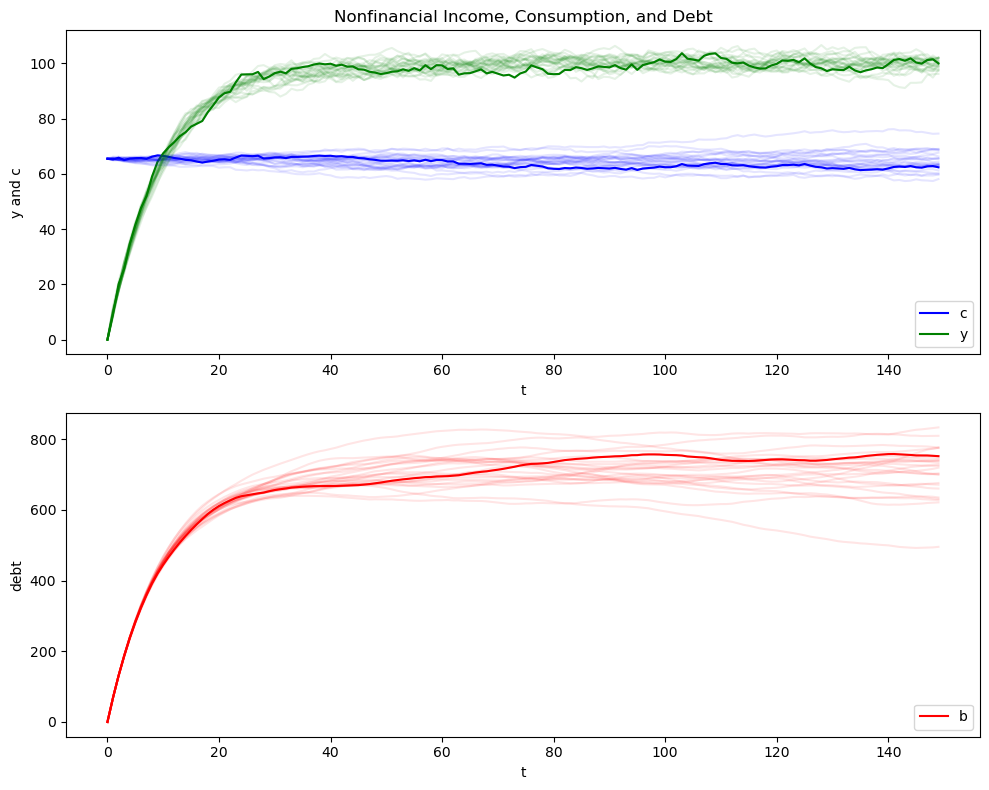

In [13]:
out = income_consumption_debt_series(A_LSS, C_LSS, G_LSS, μ_0, Σ_0)
bsim0, csim0, ysim0 = out[:3]
cons_mean0, cons_var0, debt_mean0, debt_var0 = out[3:]

consumption_income_debt_figure(bsim0, csim0, ysim0)

plt.show()

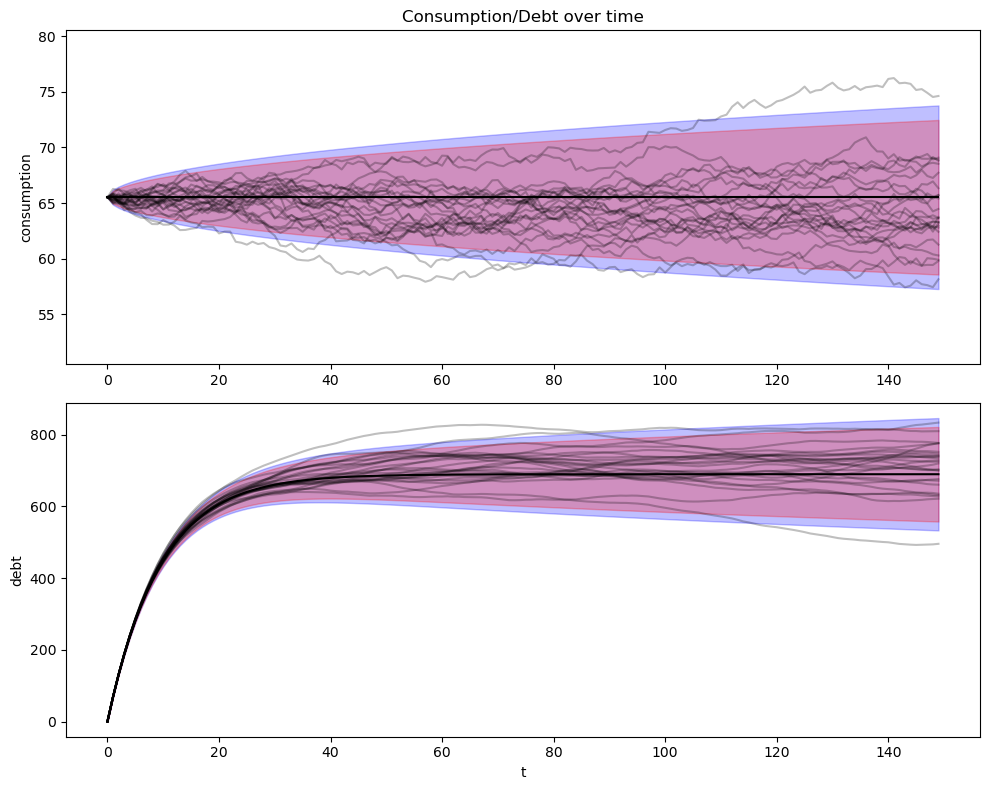

In [14]:
consumption_debt_fanchart(csim0, cons_mean0, cons_var0,
                          bsim0, debt_mean0, debt_var0)

plt.show()

Here is what is going on in the above graphs.

For our simulation, we have set initial conditions $b_0 = y_{-1} = y_{-2} = 0$.

Because $y_{-1} = y_{-2} = 0$, nonfinancial income $y_t$ starts far below its stationary mean $\mu_{y, \infty}$ and rises early in each simulation.

Recall from  the {doc}`previous lecture <perm_income>` that we can represent the optimal decision rule for consumption in terms of the **co-integrating relationship**

```{math}
:label: old12

(1-\beta) b_t + c_t = (1-\beta) E_t \sum_{j=0}^\infty \beta^j y_{t+j}
```

So at time $0$ we have

$$
c_0 = (1-\beta) E_0 \sum_{t=0}^\infty \beta^j y_{t}
$$

This tells us that consumption starts at the income that would be paid by an annuity whose value equals the expected discounted value of nonfinancial income at time $t=0$.

To support that level of consumption, the consumer borrows a lot early and consequently builds up substantial debt.

In fact, he or she incurs so much debt that eventually, in the stochastic steady state, he consumes less each period than his nonfinancial income.

He uses the gap between consumption and nonfinancial income mostly to service the interest payments due on his debt.

Thus, when we look at the panel of debt in the accompanying graph, we see that this is a group of *ex-ante* identical people each of whom starts with zero debt.

All of them accumulate debt in anticipation of rising nonfinancial income.

They expect their nonfinancial income to rise toward the invariant distribution of income, a consequence of our having started them at $y_{-1} = y_{-2} = 0$.

#### Cointegration Residual

The following figure plots realizations of the left side of {eq}`old12`, which,
{ref}`as discussed in our last lecture <coint_pi>`, is called the **cointegrating residual**.

As mentioned above, the right side can be thought of as an
annuity payment on the expected present value of future income
$E_t \sum_{j=0}^\infty \beta^j y_{t+j}$.

Early along a realization, $c_t$ is approximately constant while
$(1-\beta) b_t$ and
$(1-\beta) E_t \sum_{j=0}^\infty \beta^j y_{t+j}$ both rise
markedly as the household's present value of income and borrowing rise
pretty much together.

This example illustrates the following point: the definition
of cointegration implies that the cointegrating residual is
*asymptotically* covariance stationary, not *covariance stationary*.

The cointegrating residual for the specification with zero income and zero
debt initially has a notable transient component that dominates its
behavior early in the sample.

By altering initial conditions, we shall remove this transient in our second example to be presented below

In [15]:
def cointegration_figure(bsim, csim):
    """
    Plots the cointegration
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot((1 - β) * bsim[0, :] + csim[0, :], color="k")
    ax.plot((1 - β) * bsim.T + csim.T, color="k", alpha=.1)

    ax.set(title="Cointegration of Assets and Consumption", xlabel="t")

    return fig

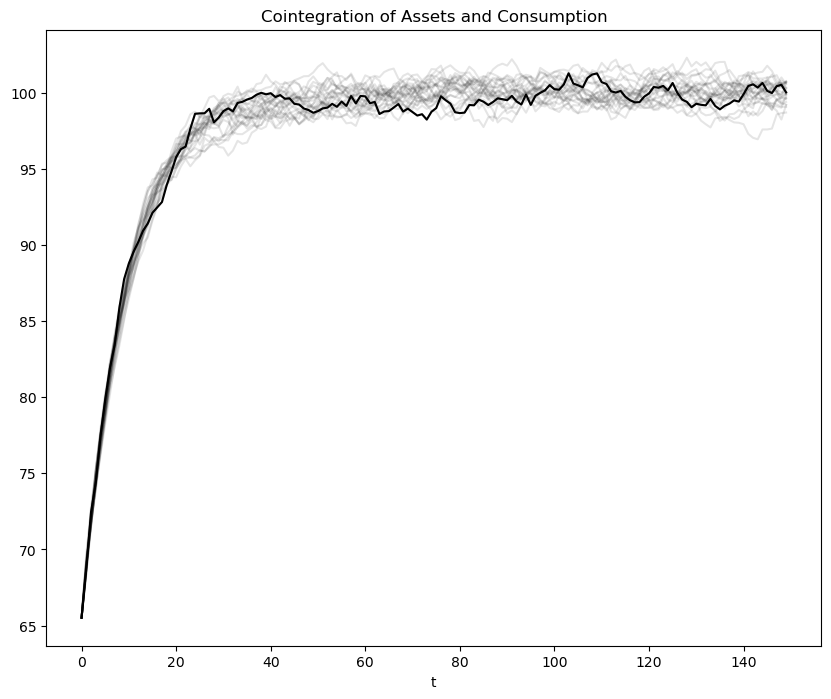

In [16]:
cointegration_figure(bsim0, csim0)
plt.show()

### A "Borrowers and Lenders" Closed Economy

When we set $y_{-1} = y_{-2} = 0$ and $b_0 =0$ in the
preceding exercise, we make debt "head north" early in the sample.

Average debt in the cross-section rises and approaches the asymptote.

We can regard these as outcomes of a "small open economy" that
borrows from abroad at the fixed gross interest rate $R = r+1$ in
anticipation of rising incomes.

So with the economic primitives set as above, the economy converges to a
steady state in which there is an excess aggregate supply of risk-free
loans at a gross interest rate of $R$.

This excess supply is filled by "foreigner lenders" willing to make those loans.

We can use virtually the same code to rig a "poor man's Bewley {cite}`Bewley86` model" in the following way

- as before, we start everyone at $b_0 = 0$.
- But instead of starting everyone at $y_{-1} = y_{-2} = 0$, we
  draw $\begin{bmatrix} y_{-1} \\ y_{-2}   \end{bmatrix}$ from
  the invariant distribution of the $\{y_t\}$ process.

This rigs a closed economy in which people are borrowing and lending
with each other at a gross risk-free interest rate of
$R = \beta^{-1}$.

Across the group of people being analyzed, risk-free loans are in zero excess supply.

We have arranged primitives so that $R = \beta^{-1}$ clears the market for risk-free loans at zero aggregate excess supply.

So the risk-free loans are being made from one person to another within our closed set of agents.

There is no need for foreigners to lend to our group.

Let's have a look at the corresponding figures

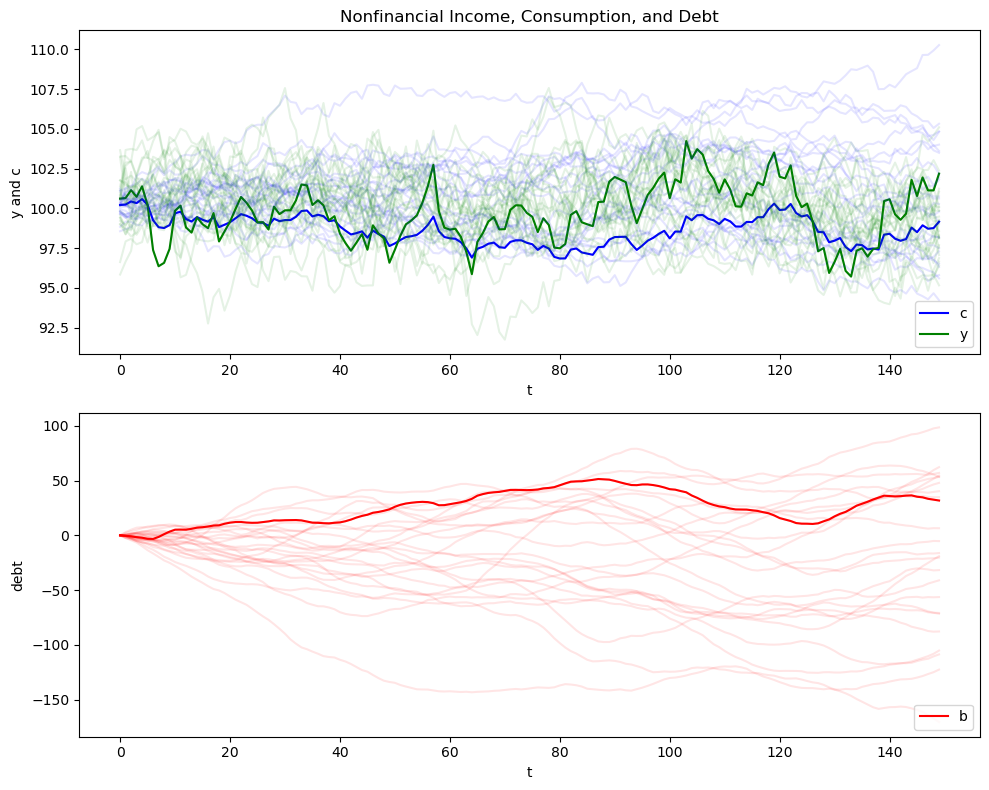

In [17]:
out = income_consumption_debt_series(A_LSS, C_LSS, G_LSS, mxbewley, sxbewley)
bsimb, csimb, ysimb = out[:3]
cons_meanb, cons_varb, debt_meanb, debt_varb = out[3:]

consumption_income_debt_figure(bsimb, csimb, ysimb)

plt.show()

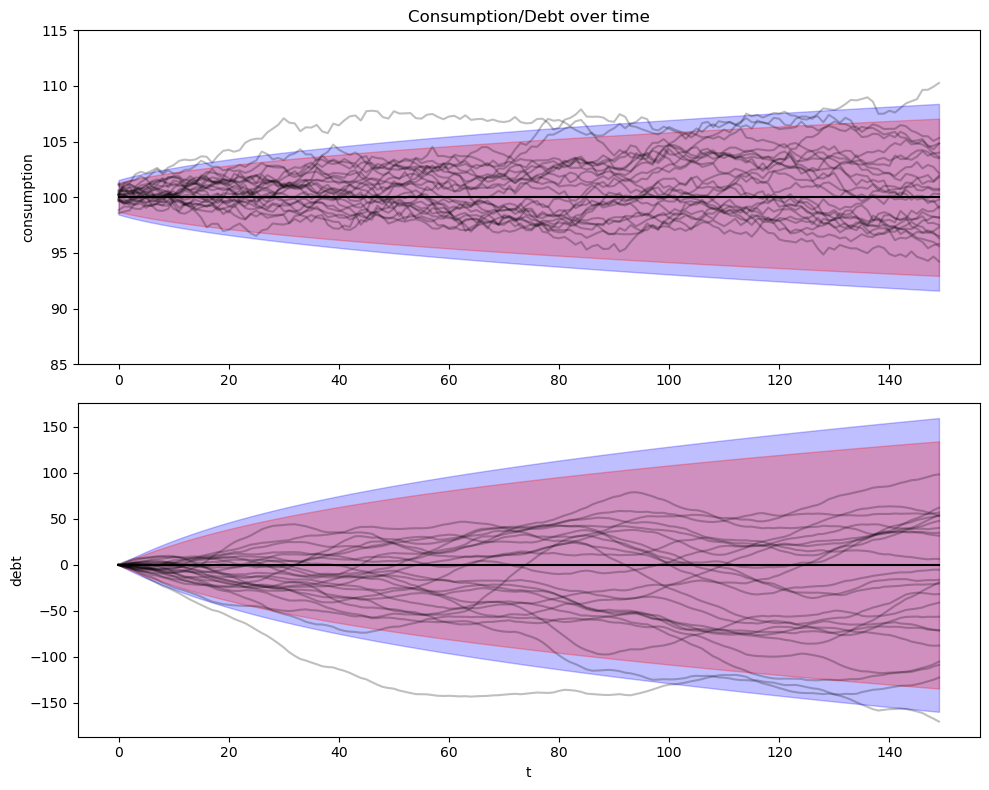

In [18]:
consumption_debt_fanchart(csimb, cons_meanb, cons_varb,
                          bsimb, debt_meanb, debt_varb)

plt.show()

The graphs confirm the following outcomes:

- As before, the consumption distribution spreads out over time.

But now there is some initial dispersion because there is *ex-ante* heterogeneity in the initial draws of $\begin{bmatrix} y_{-1} \\ y_{-2}   \end{bmatrix}$.

- As before, the cross-section distribution of debt spreads out over time.
- Unlike before, the average level of debt stays at zero, confirming that this is a closed borrower-and-lender economy.
- Now the cointegrating residual seems stationary, and not just asymptotically stationary.

Let's have a look at the cointegration figure

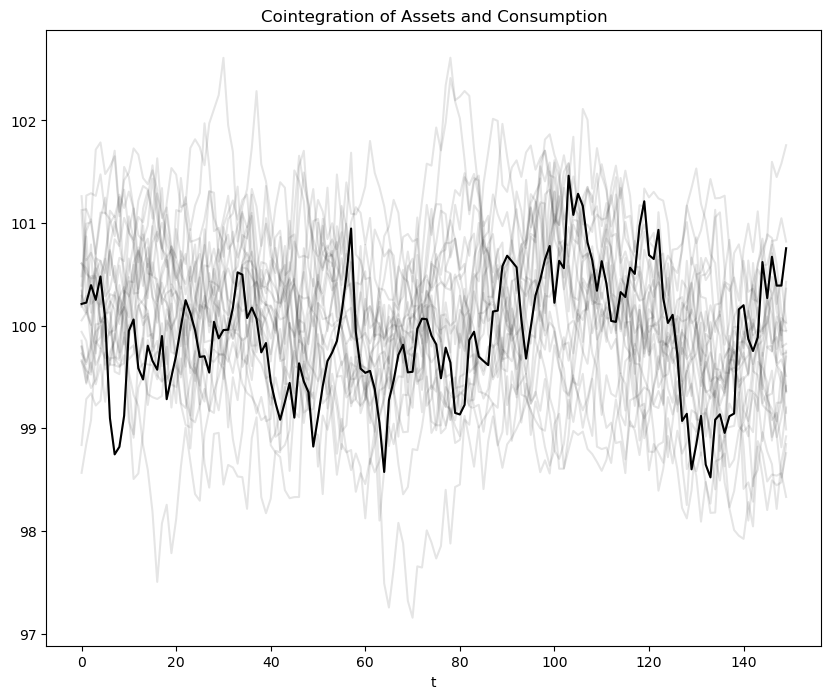

In [19]:
cointegration_figure(bsimb, csimb)
plt.show()